In [5]:
import os
import sys
import random
import warnings

import cv2
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain

%matplotlib inline

In [6]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

C:\Users\Attashe\Anaconda2\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


In [9]:
TRAIN_DIR = 'E:/GitHub/kaggle_cells/data/stage1_train/'

train_ids = os.listdir(TRAIN_DIR)
train_images = [os.path.join(TRAIN_DIR, train_id, 'images', train_id + '.png') 
                for train_id in train_ids]
train_masks = {train_id: [os.path.join(TRAIN_DIR, train_id, 'masks', img_name) 
                          for img_name in os.listdir(os.path.join(TRAIN_DIR, train_id, 'masks'))]
               for train_id in train_ids}

In [10]:
X = {train_ids[i]: cv2.imread(train_images[i]) for i in range(len(train_images))}

Y = {train_id: sum((cv2.imread(train_mask)[..., 0]
                    for train_mask in train_masks[train_id]))
     for train_id in train_ids}

In [12]:
x = np.zeros((len(train_ids),) + X[train_ids[0]].shape)
y = np.zeros((len(train_ids),) + Y[train_ids[0]].shape)
# assert(X[train_ids[0]].shape == Y[train_ids[0]].shape)
print(x.shape)

for i, ind in zip(range(len(train_ids)), train_ids):
    x[i,:, :, :] =  cv2.resize(X[ind], (256, 256))
    y[i, :, :] = cv2.resize(Y[ind], (256, 256))

(670, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


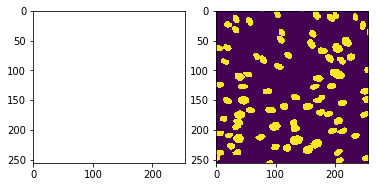

In [13]:
plt.subplot(121)
plt.imshow(x[12])
plt.subplot(122)
plt.imshow(y[12])

In [20]:
def data_generator(x, y, batch_size=10):
    for i in range(len(x) // batch_size):
        yield (x[i*batch_size:i*batch_size+batch_size], 
               y[i*batch_size:i*batch_size+batch_size])    

In [27]:
# data_gen_args = dict(rotation_range=0.2,
#                     width_shift_range=0.05,
#                     height_shift_range=0.05,
#                     shear_range=0.05,
#                     zoom_range=0.05,
#                     horizontal_flip=True,
#                     fill_mode='nearest')
#myGene = trainGenerator  # (2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)
model = unet(input_size=(256, 256, 3))
#model_checkpoint = ModelCheckpoint  # ('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(data_generator(x, y.reshape((-1, 1, 256, 256))/255, 2)
                    ,steps_per_epoch=2000,epochs=5)

C:\Users\Attashe\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Attashe\Anaconda2\envs\deeplearning\lib\site-packages\keras\legacy\layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Attashe\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Attashe\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concate

Epoch 1/5


ValueError: Error when checking target: expected conv2d_192 to have shape (256, 256, 1) but got array with shape (1, 256, 256)

In [28]:
x.shape

(670, 256, 256, 3)